# Arrests, Prison Sentencing, and Race in New York State

I analyzed the New York State 2018 arrest data to see if racial diparities exist. Analysis included adjusting for county population data and racial demographics of counties in which persons were arrested or sentenced to prison.

I found that black people are arrested and sentenced to prison dispropotionately high compared to every other demographic group. This is true especially for counties with high white population (>50%). Conversely, in counties where black people make up more than 10% of the total population black people are arrested less and yield fewer prison sentences per arrest.

This suggest that disproportionately high arrest and prison sentence of black people is due to racial biases against black people in counties with high white/ low black population.  

## Table of contents
1. [Download and data setup](#1)
2. [County Demographics](#2)
    <br>[Plot1:%white vs %black population](#plot1)
3. [Arrests for different races](#3)
    <br>[Plot2: Arrest/population for each race](#plot2)
    <br>[Plot3: Population vs arrest/population for each race](#plot3)
    <br>[Plot4: all arrests vs city](#plot4)
    <br>[Plot5: Population vs arrest/population for each race log scale](#plot5)
    <br>[Plot6: Black arrest vs city](#plot6)
4. [County demographic and arrests for each race](#4)
    <br>4.1 [Population vs. % arrest for each race](#4.1)
    <br>[Plot7: Black arrest, county size, white demographic](#plot7)
    <br>[Plot8: Black arrest vs white demographic](#plot8)
    <br>[Plot9: Black arrest vs black demographic](#plot9)
    <br>4.2 [Summary by county demographic](#4.2)
    <br>4.2.1 [White](#4.2.1)
    <br>[Plot10: Race arrest percentage vs white demographic](#plot10)
    <br>[Plot11: Arrest/population vs white demographic](#plot11)
    <br>4.2.2 [Black](#4.2.2)
    <br>[Plot12: County distribution by black population](#plot12)
    <br>[Plot13: Arrest/population vs black demographic](#plot13)
    <br>4.3 [How unfair are the arrests?](#4.3)  
    <br>[Plot14: unfairness for each race](#plot14)
    <br>[Plot15: unfairness and percent white in each county](#plot15)
    <br>[Plot16: unfairness and white demographic](#plot16)
    <br>[Plot17: unfairness and black demographic](#plot17)
5. [Prison sentences vs. arrests](#5)
    <br>[Plot18: % prison sentence vs % arrest](#plot18)
    <br>[Plot19: Prison/arrest ratio for each race ](#plot19)
    <br>[Plot20: Prison/arrest ration vs white demographic](#plot20)
    <br>[Plot21: Prison/arrest ration and white demographic](#plot21)
    <br>[Plot22: Prison/arrest ration and black demographic](#plot22)
6. [Conclusion/Main Takeaways](#6)
    

## 1. <a id='1'>Download and data setup </a>

Dataset was obtained from here:

https://www.criminaljustice.ny.gov/crimnet/ojsa/comparison-population-arrests-prison-demographics.html
File was converted from pdf to excel with this: https://simplypdf.com/Excel

In [1]:
# Import packages
import pandas as pd
import numpy as np

In [2]:
# Import packages needed for ggplot

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from plotnine import *

In [3]:
xl2 = pd.ExcelFile('prison.xlsx')

sheetnames = xl2.sheet_names  # see all sheet names

sheets = sheetnames[4:66]

# run a loop to extract data from each sheet
data3 = []
for s in sheets:
    sheetname = s
    countydata = pd.read_excel('prison.xlsx', sheet_name = sheetname, skiprows = 2,nrows = 5)
    data3.append(countydata)
    
# Create new dataframe and add extracted data to it
prison_df = pd.DataFrame()
prison_df = prison_df.append(data3,True)

In [4]:
# Rename columns
prison_df.columns = ['race','population','%population','arrest','%arrest','felonyarrest','%felony','prison','%prison']
# Resulted dataframe
prison_df.head()

,race,population,%population,arrest,%arrest,felonyarrest,%felony,prison,%prison
0,White,220533,0.72,3242,0.45,928,0.36,95,0.26
1,Black,39292,0.13,3035,0.43,1302,0.51,222,0.61
2,Hispanic,18737,0.06,630,0.09,254,0.10,47,0.13
3,Asian,20640,0.07,75,0.01,19,0.01,0,0.00
4,Other-Unknown,7915,0.03,150,0.02,52,0.02,0,0.00


In [5]:
# Get a list of county names from each sheet
counties = []
for s in sheets:
    sheetname = s
    countydata = pd.read_excel('prison.xlsx', sheet_name = sheetname, skiprows = 0,nrows = 5)
    countyname = countydata.columns[0]
    counties.append(countyname)

In [6]:
# Stack them so that it's in the same format as the rest of the data

countynames = counties
County = []
for c in countynames:
    countyname = c
    county = [[]] * 5
    county[0].append(c)
    County.append(county)
County = pd.DataFrame(County)
County = County.unstack()
# Make sure it is the right length (310)
len(County)

310

In [7]:
# Reset index
County.reset_index(drop=True, inplace = True)

In [8]:
# Sort the county names so it matches the other table

County = County.sort_values()
County.reset_index(drop=True, inplace = True)

# Add the county labels to the dataset
prison_df['County'] = County

# Remove brackets and commas 
prison_df['County'] = prison_df['County'].str.join(', ')
prison_df = prison_df.replace(',','', regex=True)




In [9]:
# Rename to df2 so that we have an unultered original
prison_df2=prison_df

In [10]:
# Convert all the numeric columns to float
prison_df2['population'] = prison_df2['population'].astype(float)
prison_df2['arrest'] = prison_df2['arrest'].astype(float)
prison_df2['felonyarrest'] = prison_df2['felonyarrest'].astype(float)
prison_df2['prison'] = prison_df2['prison'].astype(float)

In [11]:
# Calculate total prison counts 

tprison = []
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['prison']
    tot = sum(toadd)
    mult = [[]] * 5
    mult[0].append(tot)
    tprison.append(mult)
# Put it in a dataframe
tprison = pd.DataFrame(tprison)
# Put it all in one column
tprison = tprison.stack()
# Reset index
tprison.reset_index(drop=True,inplace=True)
# Add it to the prison_df2 table
prison_df2['totprison'] = tprison
# Remove brackets
prison_df2['totprison'] = prison_df2['totprison'].str[0]

In [12]:
# Calculate total population 

tpop = []
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['population']
    tot = sum(toadd)
    mult = [[]] * 5
    mult[0].append(tot)
    tpop.append(mult)
# Put it in a dataframe
tpop = pd.DataFrame(tpop)
# Put it all in one column
tpop = tpop.stack()
# Reset index
tpop.reset_index(drop=True,inplace=True)
# Add it to the prison_df2 table
prison_df2['totpopulation'] = tpop
# Remove brackets
prison_df2['totpopulation'] = prison_df2['totpopulation'].str[0]

In [13]:
# Calculate the felony (do the same)
tfelony = []
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['felonyarrest']
    tot = sum(toadd)
    mult = [[]] * 5
    mult[0].append(tot)
    tfelony.append(mult)
# Put it in a dataframe
tfelony = pd.DataFrame(tfelony)
# Put it all in one column
tfelony = tfelony.stack()
# Reset index
tfelony.reset_index(drop=True,inplace=True)
# Add it to the prison_df2 table
prison_df2['totfelony'] = tfelony
# Remove brackets
prison_df2['totfelony'] = prison_df2['totfelony'].str[0]

In [14]:
# Calculate the arrest (do the same)
tarrest = []
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['arrest']
    tot = sum(toadd)
    mult = [[]] * 5
    mult[0].append(tot)
    tarrest.append(mult)
# Put it in a dataframe
tarrest = pd.DataFrame(tarrest)
# Put it all in one column
tarrest = tarrest.stack()
# Reset index
tarrest.reset_index(drop=True,inplace=True)
# Add it to the prison_df2 table
prison_df2['totarrest'] = tarrest
# Remove brackets
prison_df2['totarrest'] = prison_df2['totarrest'].str[0]

In [15]:
# label counties that are in NY city as "NY city" and label others as "others"
data = []
for c in counties:
    if (c == 'Bronx County'or c=='Kings County'or c == 'New York County'or c == 'Queens County'or c == 'Richmond County'):
        mult = [[]] * 5
        mult[0].append('NY city')
        data.append(mult)     
    else:
        mult = [[]] * 5
        mult[0].append('Others')
        data.append(mult)  
        
data = pd.DataFrame(data)
data = data.unstack()

# Reset index
data.reset_index(drop=True, inplace = True)
# Sort the county names so it matches the other table

data = data.sort_values()
# Reset index again
data.reset_index(drop=True, inplace = True)

# Add the county labels to the dataset
prison_df2['city'] = data

# Remove brackets and commas 
prison_df2['city'] = prison_df['city'].str.join(', ')
prison_df2 = prison_df2.replace(',','', regex=True)
prison_df2['city'] = prison_df2['city'].str.replace(" ","")


In [16]:
# Add a column for % White of population for each county
perwhite = []
for c in counties:
    rows = prison_df2[(prison_df2.County == c) & (prison_df2.race == "White")]
    toadd = rows['%population']
    tot = sum(toadd) # Using this sum funciton to strip unnecessary stuff
    mult = [[]] * 5
    mult[0].append(tot)
    perwhite.append(mult)
perwhite = pd.DataFrame(perwhite)

perwhite = perwhite.stack()
perwhite.reset_index(drop=True,inplace=True)
perwhite = perwhite.str[0]

# Add to prison_df2
prison_df2['perwhite'] = perwhite

In [17]:
# Add a column for % Black of population for each county

perblack = []
for c in counties:
    rows = prison_df2[(prison_df2.County == c) & (prison_df2.race == "Black")]
    toadd = rows['%population']
    tot = sum(toadd)
    mult = [[]] * 5
    mult[0].append(tot)
    perblack.append(mult)
perblack = pd.DataFrame(perblack)

perblack = perblack.stack()
perblack.reset_index(drop=True,inplace=True)
perblack = perblack.str[0]
prison_df2['perblack'] = perblack

In [18]:
# Calculate arrest/population
prison_df2['arrestperpopulation'] = prison_df2['arrest']/prison_df2['population']

In [19]:
# Take the log of the population
prison_df2['logpop'] = np.log10(prison_df2['population'])

In [20]:
prison_df2.head()

,race,population,%population,arrest,%arrest,felonyarrest,%felony,prison,%prison,County,totprison,totpopulation,totfelony,totarrest,city,perwhite,perblack,arrestperpopulation,logpop
0,White,220533.0,0.72,3242.0,0.45,928.0,0.36,95.0,0.26,Albany County,364.0,307117.0,2555.0,7132.0,NYcity,0.72,0.13,0.014701,5.343474
1,Black,39292.0,0.13,3035.0,0.43,1302.0,0.51,222.0,0.61,Albany County,364.0,307117.0,2555.0,7132.0,NYcity,0.72,0.13,0.077242,4.594304
2,Hispanic,18737.0,0.06,630.0,0.09,254.0,0.10,47.0,0.13,Albany County,364.0,307117.0,2555.0,7132.0,NYcity,0.72,0.13,0.033623,4.272700
3,Asian,20640.0,0.07,75.0,0.01,19.0,0.01,0.0,0.00,Albany County,364.0,307117.0,2555.0,7132.0,NYcity,0.72,0.13,0.003634,4.314710
4,Other-Unknown,7915.0,0.03,150.0,0.02,52.0,0.02,0.0,0.00,Albany County,364.0,307117.0,2555.0,7132.0,NYcity,0.72,0.13,0.018951,3.898451


## 2. <a id='2'>County Demographics </a>

In [21]:
# Quick look at county demographics
countydem = prison_df2[['County','race','city','%population']]
countydem = countydem.pivot(index = ['County','city'],columns='race', values='%population')
countydem = countydem.reset_index()

#### Plot1: <a id='plot1'>% white vs % black population </a>

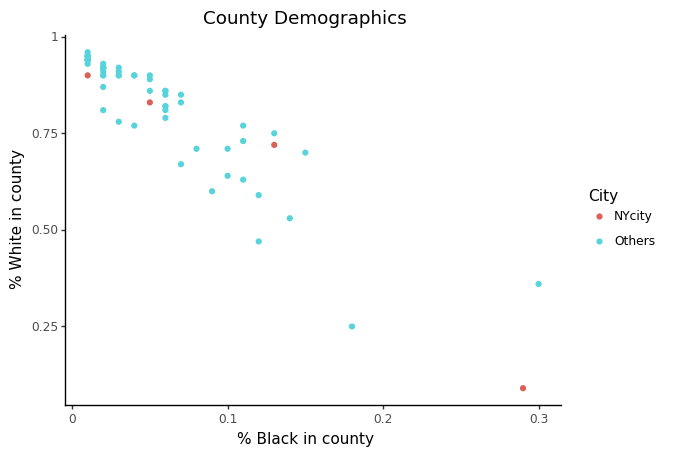

<ggplot: (7019524945)>

In [64]:
(ggplot(countydem, aes(x= 'Black', y='White', color='city')) 
 + geom_point()
 + ggtitle('County Demographics')
 + theme_classic()
 + ylab('% White in county')
 + xlab('% Black in county')
 + labs(color='City')
)

There is an overall inverse relationship between percent of white people and black people in counties, as expected. The racial demographics in NYC counties (Bronx, Kings, New York, Queens, Richmond) are comparable to other counties in NY State.

## 3. <a id='3'>Arrests for different races </a>

#### Plot2: <a id='plot2'>Arrest/population for each race </a>

In [23]:
mean = prison_df2.groupby('race').mean()
mean = mean.reset_index()
semsum = prison_df2.groupby('race').sem()
sem = semsum.loc[:,('arrestperpopulation')].tolist()
meanratio = mean.loc[:,('race','arrestperpopulation')]
meanratio['sem'] = sem
meanratio['ymin'] = meanratio['arrestperpopulation'] - meanratio['sem']
meanratio['ymax'] = meanratio['arrestperpopulation'] + meanratio['sem']



In [24]:
meanratio

,race,arrestperpopulation,sem,ymin,ymax
0,Asian,0.009465,0.001173,0.008292,0.010637
1,Black,0.081617,0.004762,0.076855,0.086379
2,Hispanic,0.025879,0.001105,0.024774,0.026983
3,Other-Unknown,0.014691,0.001183,0.013507,0.015874
4,White,0.016208,0.000595,0.015613,0.016804


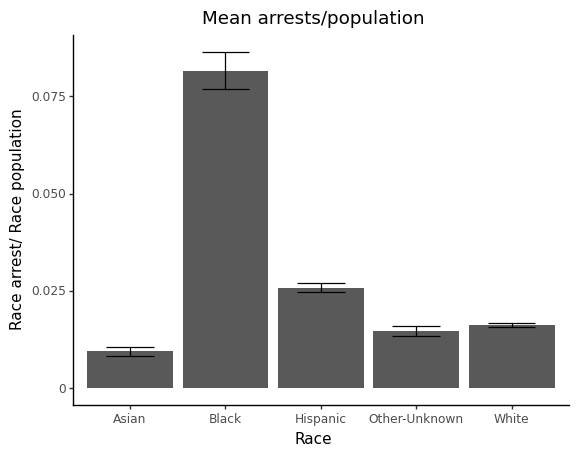

<ggplot: (7020303877)>

In [25]:
(ggplot(meanratio, aes(x='race',y='arrestperpopulation')) 
 + geom_col()
 + theme_classic()
 + geom_errorbar(aes(x='race',ymin='ymin',ymax='ymax'))
 + xlab('Race')
 + ylab('Race arrest/ Race population')
 + ggtitle('Mean arrests/population')
)

On average, higher population of black people are arrested compared to other races.

#### Plot3: <a id='plot3'>Population vs arrest/population for each race </a>

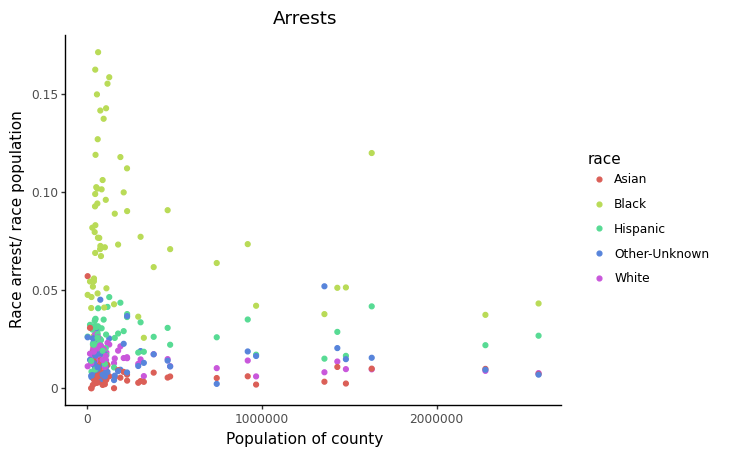

<ggplot: (7020166761)>

In [26]:
(ggplot(prison_df2, aes(x= 'totpopulation', y='arrestperpopulation',color = 'race')) 
 + geom_point()
 + ggtitle('Arrests')
 + ylab('Race arrest/ race population')
 + xlab('Population of county')
 + theme_classic()
 + labs(color='Race')
)

When looked at by county, arrest/population for minorities, especially black people are higher than white people in low populated counties. 

#### Plot4: <a id='plot4'>Population vs arrest/population for each race log scale </a>

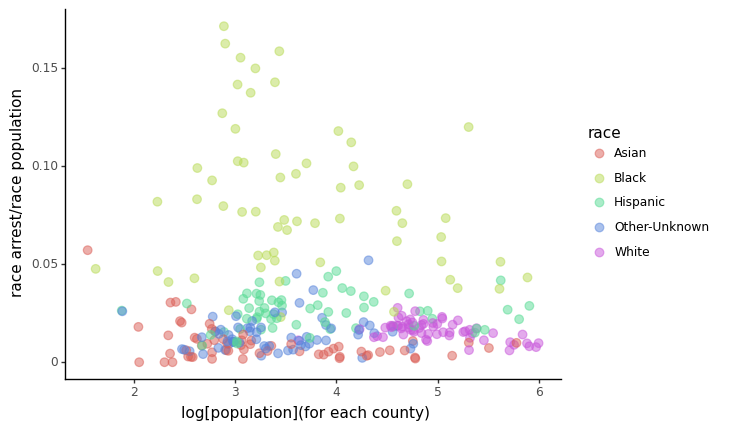

<ggplot: (285624329)>

In [27]:
(ggplot(prison_df2, aes(x="logpop", y="arrestperpopulation", color='race')) 
 + geom_point(size=3,alpha=0.5) 
 + xlab('log[population](for each county)')
 + ylab('race arrest/race population')
 + theme_classic()
 + labs(color='Race')
)

Transformed the x axis to log scale to see the relationship between population and arrest/population better. Black people are arrested at a higher percentage than other race accross the board.

#### Plot5: <a id='plot5'>Arrests vs city </a>

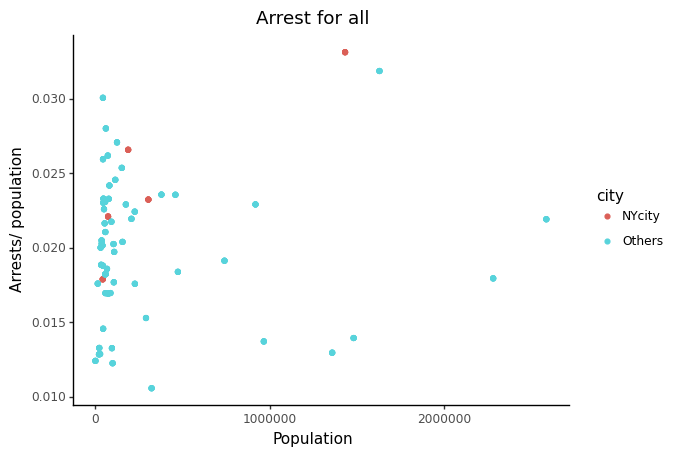

<ggplot: (7019976497)>

In [28]:
(ggplot(prison_df2, aes(x= 'totpopulation', y='totarrest/totpopulation',color = 'city')) 
 + geom_point()
 + ggtitle('Arrest for all')
 + ylab('Arrests/ population')
 + xlab('Population')
 + theme_classic()
 + labs(color='City')
)

Arrests overall does not seem to depend on the size of the county or the location (NY city vs other counties).

#### Plot6: <a id='plot6'>Black arrest vs city </a>

In [29]:
black = prison_df2[(prison_df2.race == 'Black')]

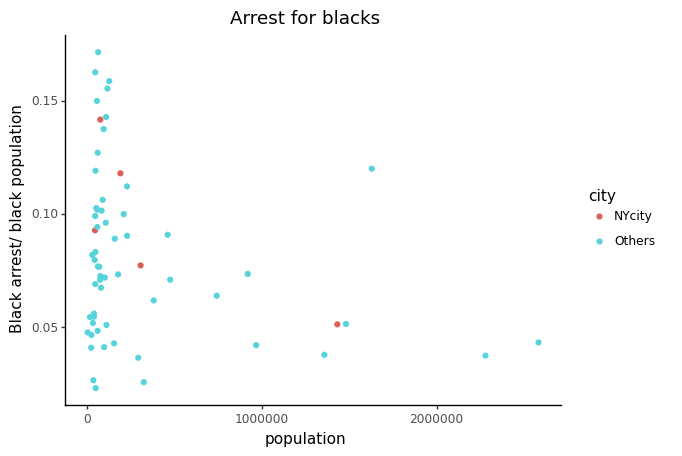

<ggplot: (7019699365)>

In [30]:
(ggplot(black, aes(x= 'totpopulation', y='arrestperpopulation',color = 'city')) 
 + geom_point()
 + ggtitle('Arrest for blacks')
 + ylab('Black arrest/ black population')
 + xlab('population')
 + theme_classic()
 + labs(color='City')
)

Arrests/poppulation for black people also doesn't depend the location (NY city vs other counties), but is lower in higher populated counties.

## 4. <a id='4'>County demographic and arrests for each race </a>

### 4.1 <a id='4.1'> Distribution of all counties</a>

In [31]:

# Add a column white demographic for each county

whitedems = []
whiteper = prison_df2['perwhite']

for w in whiteper:
    if w > 0.5:
        racedem = 'white >0.5'
    else:
        racedem = 'white <=0.5'
    whitedems.append(racedem)    


prison_df2['whitedems'] = whitedems



#### Plot7: <a id='plot7'>Black arrest, county size, white demographic </a>

In [32]:
black = prison_df2[(prison_df2.race == 'Black')]

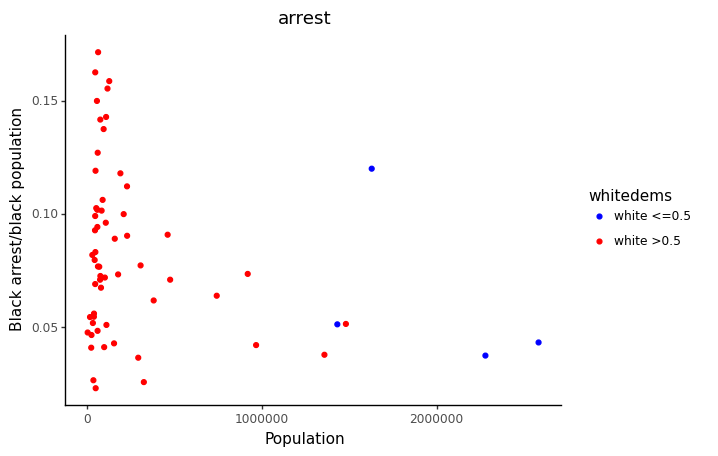

<ggplot: (7020055033)>

In [33]:
(ggplot(black, aes(x= 'totpopulation', y='arrestperpopulation',color = 'whitedems'))
 + geom_point()
 + scale_color_manual(values={'white >0.5':'red','white <=0.5':'blue'})
 + ggtitle('Black arrests and county population')
 + ylab('Black arrest/black population')
 + xlab('Population')
 + theme_classic()
 + labs(color='White demographic')
)

Black people are arrested more in small counties and those with low percentage of white population.

#### Plot8: <a id='plot8'>Black arrest vs white demographic </a>

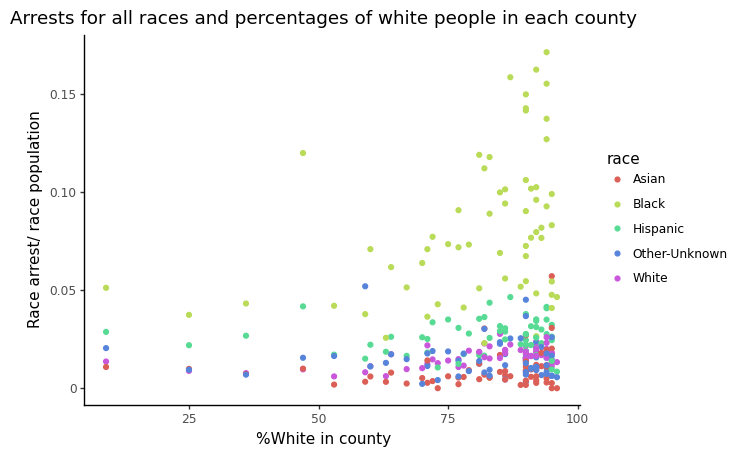

<ggplot: (7020122729)>

In [65]:
(ggplot(prison_df2, aes(x= 'perwhite*100', y='arrestperpopulation',color = 'race')) 
 + geom_point()
 + ggtitle('Arrests for all races and percentages of white people in each county')
 + ylab('Race arrest/ race population')
 + xlab('%White in county')
 + theme_classic()
 + labs(color='Race')
)

The more white people are in the county, the more percentage of black and hispanic people seem to get arrested.

#### Plot9: <a id='plot9'>Black arrest vs black demographic </a>

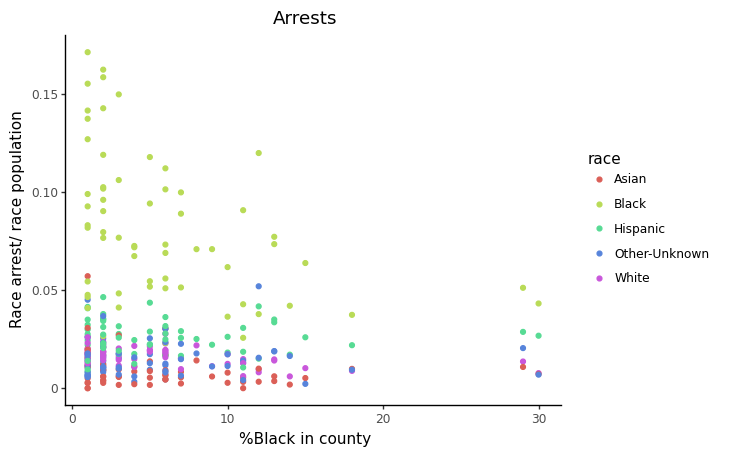

<ggplot: (7020150149)>

In [35]:
(ggplot(prison_df2, aes(x= 'perblack*100', y='arrestperpopulation',color = 'race')) 
 + geom_point()
 + ggtitle('Arrests for all races and percentages of black people in each county')
 + ylab('Race arrest/ race population')
 + xlab('%Black in county')
 + theme_classic()
 + labs(color='Race')
)

On the conterary, the more the black people are in the county, the less black people get arrested.

### 4.2 <a id='4.2'> Summary by county demographic </a>

 4.2.1 <a id='4.2.1'> White demographic and County demographic </a>

In [36]:
# Create a dataframe from groupby summary table
whitesum = prison_df2.groupby(['whitedems','race']).sum()
whitesum = whitesum.reset_index()

whiteminorows = whitesum[(whitesum.whitedems == 'white <=0.5')]
totarrestwhiteminority = sum(whiteminorows['arrest'])
whitemajrows = whitesum[(whitesum.whitedems == 'white >0.5')]
totarrestwhitemajority = sum(whitemajrows['arrest'])
whitemin = whiteminorows['arrest']/totarrestwhiteminority
whitemaj = whitemajrows['arrest']/totarrestwhitemajority
arrestwhite = pd.DataFrame(whitemin)
whitemaj.reset_index(drop=True, inplace = True)
arrestwhite['whitemaj'] = whitemaj
race = ['Asian','Black','Hispanic','Unknown','White']
arrestwhite['race'] = race
arrestwhite.columns = ['white <=0.5','white >0.5','race']
arrestwhite = pd.melt(arrestwhite, id_vars = ['race'], value_vars = ['white <=0.5','white >0.5'])
arrestwhite.columns = ['race','whitedem','arrestpercent']
arrestwhite['arrestpercent'] = arrestwhite['arrestpercent']*100
# Round up decimal 
arrestwhite['arrestpercent'] = round(arrestwhite['arrestpercent'],1)

#### Plot10: <a id='plot10'>Race arrest percentage vs white demographic </a>

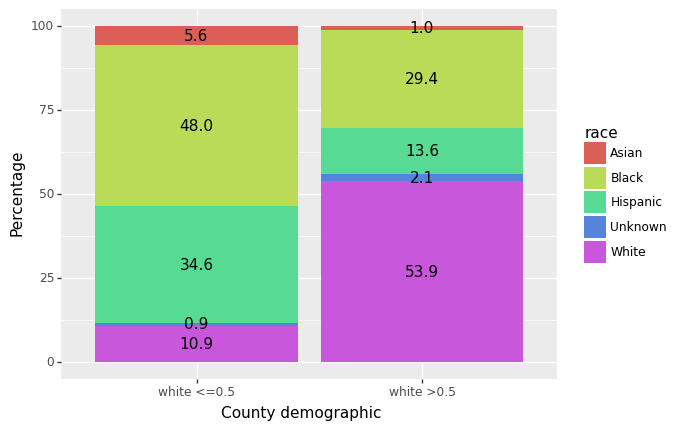

<ggplot: (7020016017)>

In [37]:
(ggplot(arrestwhite, aes(x='whitedem', y='arrestpercent', fill='race'))
 + geom_col() 
 + xlab('County demographic')
 + ylab('arrest/total arrest')
 + geom_text(aes(x='whitedem', y='arrestpercent', label='arrestpercent'),position = position_stack(vjust = 0.5))
 + labs(color='Race')
 + theme_classic()
)

It is hard to tell how fair the arrests are by just looking at the percentage of arrest for each race/total arrest. At a glance, it does look like white people are getting arrested more in higher rate than other races as expected.

In [38]:
# Get the mean with groupby
whitemean = prison_df2.groupby(['whitedems','race']).mean()
whitemean = whitemean.reset_index()
# Calculate standard error (sem)
whitesem = prison_df2.groupby(['whitedems','race']).sem()
whitesem = whitesem.reset_index()
# extract row and convert to list
sem = whitesem.loc[:,('arrestperpopulation')].tolist()
whitearrpop = whitemean.loc[:,('whitedems','race','arrestperpopulation')]
whitearrpop['sem'] = sem
# get ymin and ymax for errorbars
whitearrpop['ymin'] = whitearrpop['arrestperpopulation'] - sem
whitearrpop['ymax'] = whitearrpop['arrestperpopulation'] + sem

#### Plot11: <a id='plot11'>Race arrest/population vs white demographic </a>

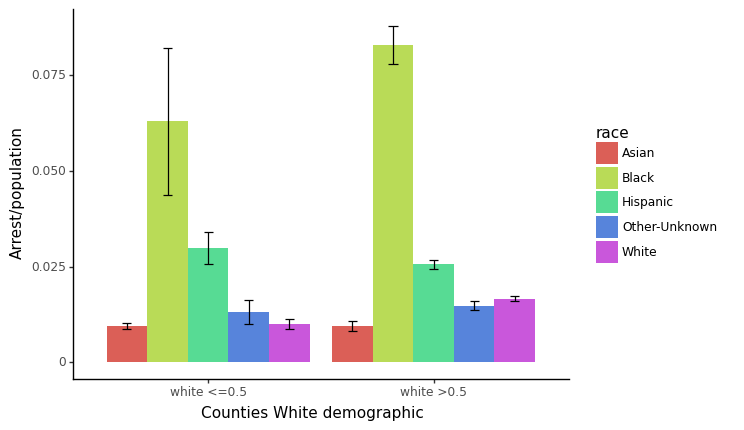

<ggplot: (7019889105)>

In [39]:
(ggplot(whitearrpop, aes(x='whitedems', y='arrestperpopulation', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 # dodge puts it at the right place
 + theme_classic()
 + ylab("Arrest/population")
 + xlab("Counties White demographic")
 + labs(color='Race')
)

However, when you compare the raw numbers of arrest/population, you can see that not only black arrests are disproportionately high but also that it get's worse when white people are the majority.

 4.2.2 <a id='4.2.2'> Black demographic and arrest demographic </a>

#### Plot12: <a id='plot12'>County distribution by black population </a>

/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


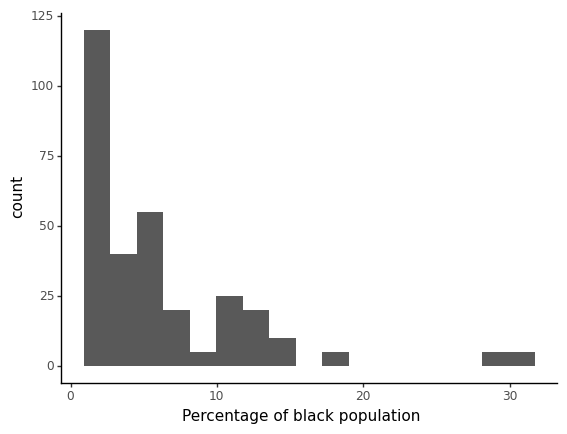

<ggplot: (7020015905)>

In [68]:
# Quick look at the distribution of counties/black demographic
(ggplot(prison_df2,aes(x='perblack*100')) 
 + geom_histogram()
 + theme_classic()
 + xlab('Percentage of black population')
)

The distribution of counties by black population shows that, in all counties, black popultion is less than 40%. For following figures deviding the counties by black population, I will be using 10% as the cuttoff. 

In [41]:
# Create a column for black demographic for each county
blackdems = []
blackper = prison_df2['perblack']

for w in blackper:
    if w > 0.1:
        racedem = 'black >0.1'
    else:
        racedem = 'black <=0.1'
    blackdems.append(racedem)    


prison_df2['blackdems'] = blackdems

In [42]:
# Get the mean with groupby
blackmean = prison_df2.groupby(['blackdems','race']).mean()
blackmean = blackmean.reset_index()
# Calculate standard error (sem)
blacksem = prison_df2.groupby(['blackdems','race']).sem()
blacksem = blacksem.reset_index()
# extract row and convert to list
sem = blacksem.loc[:,('arrestperpopulation')].tolist()
blackarrpop = blackmean.loc[:,('blackdems','race','arrestperpopulation')]
blackarrpop['sem'] = sem
# get ymin and ymax for errorbars
blackarrpop['ymin'] = blackarrpop['arrestperpopulation'] - sem
blackarrpop['ymax'] = blackarrpop['arrestperpopulation'] + sem

#### Plot13: <a id='plot13'>Race arrest/population vs black demographic </a>

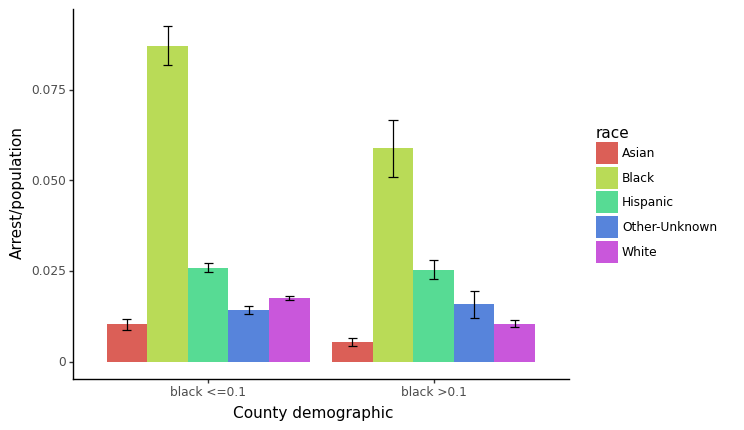

<ggplot: (7020272305)>

In [43]:
(ggplot(blackarrpop, aes(x='blackdems', y='arrestperpopulation', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 + ylab('Arrest/population')
 + xlab('County demographic')
 # dodge puts it at the right place
 + theme_classic()
 + labs(color='Race')
)

Black people get arrested less in counties with higher black population. 

### 4.3 <a id='4.2'> How unfair are the arrests? </a>

The "Unfairness factor" is the %Arrest/%population for each race. If everyone is arrested at the same rate, unfairness factor should be 1 for all races.

In [44]:
# re-calculate % population because the original data is missing decimal points
recalcpop = []
race = ['White','Black','Hispanic','Asian','Other-Unknown' ]
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['population']
    tot = sum(toadd)
    for r in race:
        racerow = rows[(prison_df2.race == r)]
        rpop = racerow['population']
        totr = sum(rpop)
        percent = totr/tot
        recalcpop.append(percent)

# Add it to the prison_df2 table
prison_df2['recalc%pop'] = recalcpop

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [45]:
# re-calculate % arrest to be exact
recalcarrest = []
race = ['White','Black','Hispanic','Asian','Other-Unknown' ]
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['arrest']
    tot = sum(toadd)
    for r in race:
        racerow = rows[(prison_df2.race == r)]
        rpop = racerow['arrest']
        totr = sum(rpop)
        percent = totr/tot
        recalcarrest.append(percent)

# Add it to the prison_df2 table
prison_df2['recalc%arrest'] = recalcarrest

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [46]:
# Calculate an unfair factor and name it 'ratio'
prison_df2['ratio'] = (prison_df2['recalc%arrest']+0.001)/(prison_df2['recalc%pop']+0.001) 

In [47]:
mean = prison_df2.groupby('race').mean()
mean = mean.reset_index()
semsum = prison_df2.groupby('race').sem()
# extract standard error as list
sem = semsum.loc[:,('ratio')].tolist()
meanratio = mean.loc[:,('race','ratio')]
meanratio['sem'] = sem
meanratio['ymin'] = meanratio['ratio'] - meanratio['sem']
meanratio['ymax'] = meanratio['ratio'] + meanratio['sem']





#### Plot14: <a id='plot14'>Unfairness for each race </a>

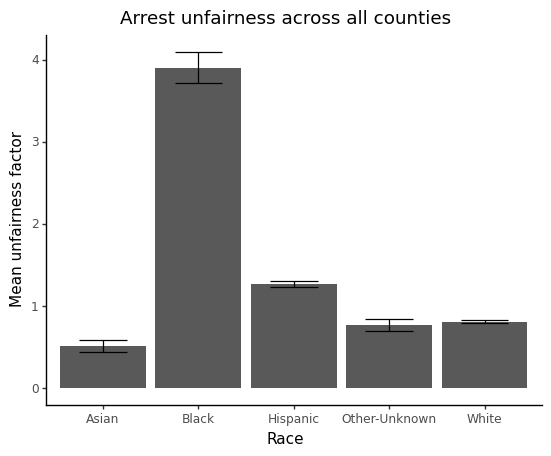

<ggplot: (7019767433)>

In [48]:
(ggplot(meanratio, aes(x='race',y='ratio')) 
 + geom_col()
 + theme_classic()
 + geom_errorbar(aes(x='race',ymin='ymin',ymax='ymax'))
 + xlab('Race')
 + ylab('Mean unfairness factor')
 + ggtitle('Arrest unfairness across all counties')
)

NY State counties, black people are arrested unfairly on average.

#### Plot15: <a id='plot15'>Unfairness and percent white in county </a>

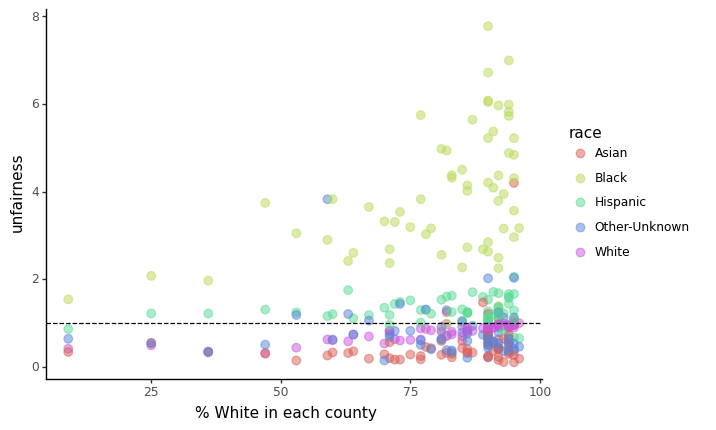

<ggplot: (7019669917)>

In [49]:
# Plot the arrest per population for each race
(ggplot(prison_df2, aes(x="perwhite*100", y="ratio", color='race')) 
 + geom_point(size=3,alpha=0.5) 
 + xlab('% White in each county')
 + ylab('unfairness')
 + geom_hline(yintercept=1,linetype='dashed')
 + theme_classic()
 + labs(color='Race')
)

Unfairness factor values for black people gets worse as the percentages of white people gets higher in the counties.

In [50]:
# Get the mean with groupby
whitemean = prison_df2.groupby(['whitedems','race']).mean()
whitemean = whitemean.reset_index()

# Calculate standard error (sem)
whitesem = prison_df2.groupby(['whitedems','race']).sem()
whitesem = whitesem.reset_index()
sem = whitesem.loc[:,('ratio')].tolist()
whitearrpop = whitemean.loc[:,('whitedems','race','ratio')]
whitearrpop['sem'] = sem
# get ymin and ymax for errorbars
whitearrpop['ymin'] = whitearrpop['ratio'] - sem
whitearrpop['ymax'] = whitearrpop['ratio'] + sem

#### Plot16: <a id='plot16'>Unfairness and white demographic </a>

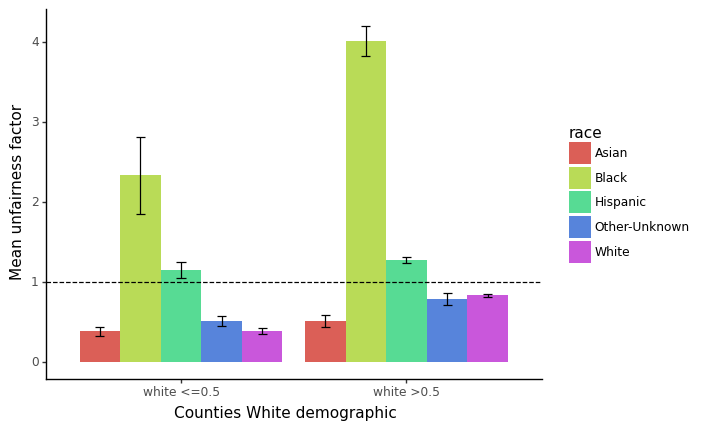

<ggplot: (7020125201)>

In [51]:
(ggplot(whitearrpop, aes(x='whitedems', y='ratio', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 # dodge puts it at the right place
 + theme_classic()
 + ylab("Mean unfairness factor")
 + xlab("Counties White demographic")
 + geom_hline(yintercept=1,linetype='dashed')
 + labs(color='Race')
)

Unfairness factor values for black people is worse in counties with high percenage of white people.

In [52]:
# Get the mean with groupby
blackmean = prison_df2.groupby(['blackdems','race']).mean()
blackmean = blackmean.reset_index()

# Calculate standard error (sem)
blacksem = prison_df2.groupby(['blackdems','race']).sem()
blacksem = blacksem.reset_index()
sem = blacksem.loc[:,('ratio')].tolist()
blackarrpop = blackmean.loc[:,('blackdems','race','ratio')]
blackarrpop['sem'] = sem
# get ymin and ymax for errorbars
blackarrpop['ymin'] = blackarrpop['ratio'] - sem
blackarrpop['ymax'] = blackarrpop['ratio'] + sem

#### Plot17: <a id='plot17'>Unfairness and black demographic </a>

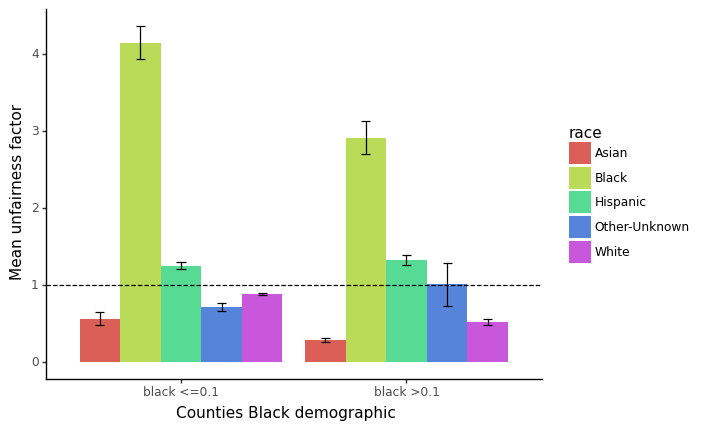

<ggplot: (7019543013)>

In [53]:
(ggplot(blackarrpop, aes(x='blackdems', y='ratio', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 # dodge puts it at the right place
 + theme_classic()
 + ylab("Mean unfairness factor")
 + xlab("Counties Black demographic")
 + geom_hline(yintercept=1,linetype='dashed')
 + labs(color='Race')
)

Black people are arrested less unfairly when there are more black people in the counties.

## 5. <a id='5'>Prison sentences for each race </a>

#### Plot18: <a id='plot18'>% Prison sentence vs % arrest </a>

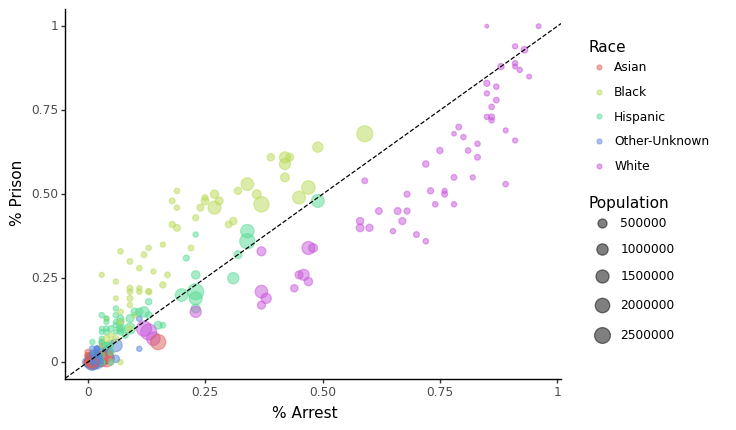

<ggplot: (7019623409)>

In [54]:
(ggplot(prison_df2, aes(x="%arrest", y="%prison", color='race', size ='totpopulation')) 
 + geom_point(alpha=0.5) 
 + geom_abline(intercept = 0 , slope = 1,linetype="dashed")
 + xlab("% Arrest")
 + ylab("% Prison")
 + labs(color='Race',size='Population')
 + theme_classic()
)

If everyone arrested were sentenced to prison fairly, all points should be on the diagonal line. However, most values for black population are above and most white population are below the diagonal line, indicating that black arrestees are disproportionately sentenced to prison and white arrestees are treated favorably.

In [55]:
# re-calculate % prison to be exact
recalcprison = []
race = ['White','Black','Hispanic','Asian','Other-Unknown' ]
# Extract data for each county and sum up numbers
for c in counties:
    rows = prison_df2[(prison_df2.County == c)]
    toadd = rows['prison']
    tot = sum(toadd)
    for r in race:
        racerow = rows[(prison_df2.race == r)]
        rpop = racerow['prison']
        totr = sum(rpop)
        percent = totr/tot
        recalcprison.append(percent)

# Add it to the prison_df2 table
prison_df2['recalc%prison'] = recalcprison

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [56]:
prison_df2['prisonratio'] = (prison_df2['recalc%prison']+0.01)/(prison_df2['recalc%arrest']+0.01)
# Added 0.01 to adjust for the very small numbers
mean = prison_df2.groupby('race').mean()
mean = mean.reset_index()
semsum = prison_df2.groupby('race').sem()
# extract standard error as list
sem = semsum.loc[:,('prisonratio')].tolist()
meanratio = mean.loc[:,('race','prisonratio')]  
meanratio['sem'] = sem
meanratio['ymin'] = meanratio['prisonratio'] - meanratio['sem']
meanratio['ymax'] = meanratio['prisonratio'] + meanratio['sem']

#### Plot19: <a id='plot19'>Prison/arrest ratio for each race </a>

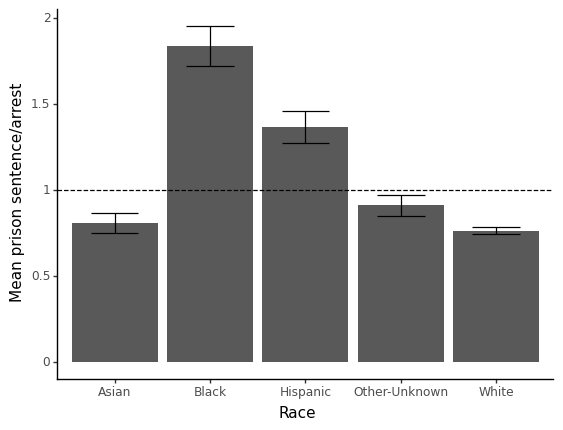

<ggplot: (7019969981)>

In [57]:
(ggplot(meanratio, aes(x='race',y='prisonratio')) 
 + geom_col()
 + theme_classic()
 + geom_errorbar(aes(x='race',ymin='ymin',ymax='ymax'))
 + xlab('Race')
 + ylab('Mean prison sentence/arrest')
 + geom_hline(yintercept=1, linetype='dashed')
)

As seen in the scatter plot ([plot18](#plot18)), black people are sentenced to prison disproportionately. While it was not obvious in the scatter plot, hispanic people are also sentenced to prison more than other races. 

In [58]:
prison_df2[(prison_df2.prisonratio > 4)]

,race,population,%population,arrest,%arrest,felonyarrest,%felony,prison,%prison,County,...,perblack,arrestperpopulation,logpop,whitedems,blackdems,recalc%pop,recalc%arrest,ratio,recalc%prison,prisonratio
76,Black,867.0,0.02,23.0,0.03,12.0,0.06,9.0,0.26,Essex County,...,0.02,0.026528,2.938019,white >0.5,black <=0.1,0.023244,0.032717,1.390735,0.257143,6.253794
286,Black,1799.0,0.03,87.0,0.07,61.0,0.15,39.0,0.33,Washington County,...,0.03,0.048360,3.255031,white >0.5,black <=0.1,0.029397,0.067547,2.255054,0.327731,4.355203


#### Plot20: <a id='plot20'>Prison/arrest ratio vs white demographic </a>

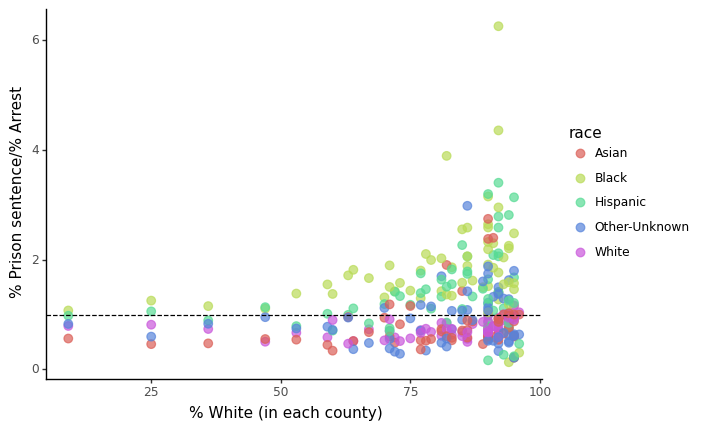

<ggplot: (7019956861)>

In [59]:
(ggplot(prison_df2, aes(x="perwhite*100", y="prisonratio", color='race')) 
 + geom_point(size=3,alpha=0.7) 
 + xlab('% White (in each county)')
 + ylab('% Prison sentence/% Arrest')
 + theme_classic()
 + geom_hline(yintercept=1,linetype='dashed')
 + labs(color='Race')
)

The higher the percentages of white people in the county, the more black and hispanic arrestees are sentenced to prison, .

In [60]:
# Get the mean with groupby
whitemean = prison_df2.groupby(['whitedems','race']).mean()
whitemean = whitemean.reset_index()
# Calculate standard error (sem)
whitesem = prison_df2.groupby(['whitedems','race']).sem()
whitesem = whitesem.reset_index()
sem = whitesem.loc[:,('prisonratio')].tolist()
whitearrpop = whitemean.loc[:,('whitedems','race','prisonratio')]
whitearrpop['sem'] = sem
# get ymin and ymax for errorbars
whitearrpop['ymin'] = whitearrpop['prisonratio'] - sem
whitearrpop['ymax'] = whitearrpop['prisonratio'] + sem

#### Plot21: <a id='plot21'>Prison/arrest ratio and white demographic </a>

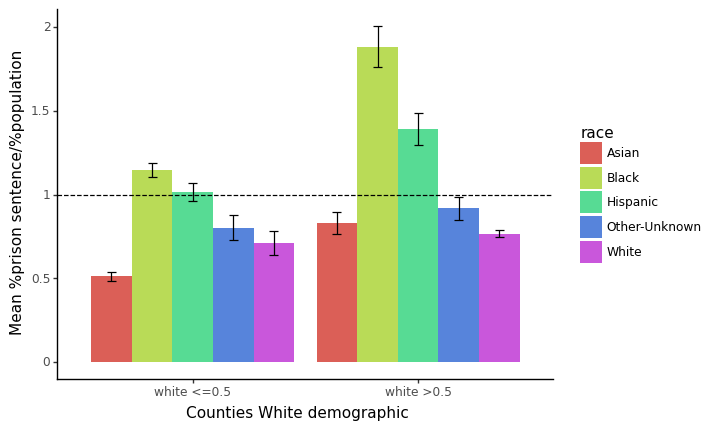

<ggplot: (7020225545)>

In [61]:
(ggplot(whitearrpop, aes(x='whitedems', y='prisonratio', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 # dodge puts it at the right place
 + theme_classic()
 + ylab("Mean %prison sentence/%population")
 + xlab("Counties White demographic")
 + geom_hline(yintercept=1,linetype='dashed')
 + labs(color='Race')
)

More black and hispanic arrestees sentenced to prison in counties with high white population.

In [62]:
# Get the mean with groupby
blackmean = prison_df2.groupby(['blackdems','race']).mean()
blackmean = blackmean.reset_index()
# Calculate standard error (sem)
blacksem = prison_df2.groupby(['blackdems','race']).sem()
blacksem = blacksem.reset_index()
sem = blacksem.loc[:,('prisonratio')].tolist()
blackarrpop = blackmean.loc[:,('blackdems','race','prisonratio')]
blackarrpop['sem'] = sem
# get ymin and ymax for errorbars
blackarrpop['ymin'] = blackarrpop['prisonratio'] - sem
blackarrpop['ymax'] = blackarrpop['prisonratio'] + sem

#### Plot22: <a id='plot22'>Prison/arrest ratio and black demographic </a>

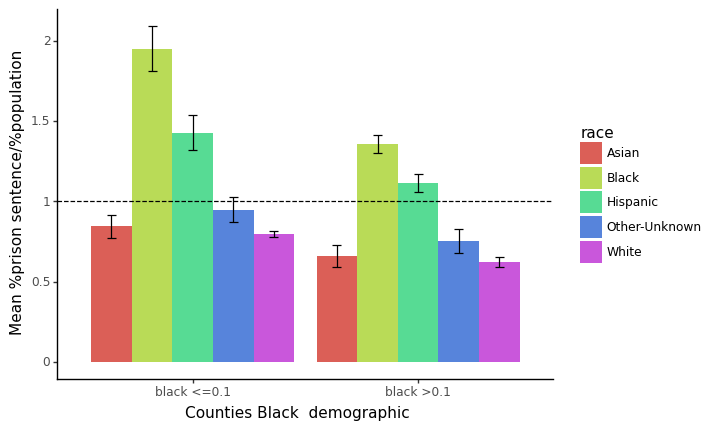

<ggplot: (7020011517)>

In [63]:
(ggplot(blackarrpop, aes(x='blackdems', y='prisonratio', fill='race')) 
 + geom_bar(position=position_dodge(), stat="identity") 
 + geom_errorbar(aes(ymin='ymin', ymax='ymax'),
                 width=.2,position=position_dodge(.9))
 # dodge puts it at the right place
 + theme_classic()
 + ylab("Mean %prison sentence/%population")
 + xlab("Counties Black  demographic")
 + geom_hline(yintercept=1,linetype='dashed')
 + labs(color='Race')
)

Less black and hispanic arrestees sentenced to prison in counties with high black population.

## 6. <a id='6'>Conclusion/Main Takaways </a>

1. Substantially more black people/(race)population are arrested in counties with high percentages of white people (see ([#3](#3),[#4.2.1](#4.2.1),[#4.3](#4.3)). The overall population size or location (NYC/non-NYC) of the county doesn't seem to matter (see [#4.1](#4.1)). 
2. The more black people there are in the community, the fewer black people get arrested (/black population) (see [#4.2.1](#4.2.1))
3. More black arrestees are sentenced to prison compared to other races/ethnicities (see [#5](#5), this effect is amplified in counties with high white demographic (see [#5](#5)).

These data describe arrests and convictions that happened in calendar year 2018 and were deidentifed for anonymity by New York State. As a result, we don't know which arrests represent repeat offenders, or how many of the arrests during 2018 led to prison sentences within that same year. Regardless of these factors, the data indicate that racial disparities have an observable effect on crime and the criminal justice system in New York State, from police apprehension all the way through the court system.